# Install Torch

In [1]:
torchver = "0.4.0"

In [2]:
!/opt/bin/nvidia-smi || /usr/bin/nvidia-smi

/bin/sh: 1: /opt/bin/nvidia-smi: not found
Sat May 26 00:55:46 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.25                 Driver Version: 390.25                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 980     Off  | 00000000:01:00.0  On |                  N/A |
| 18%   58C    P8    16W / 185W |    221MiB /  4038MiB |      4%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                 

In [3]:
!ls /colabtools

ls: cannot access '/colabtools': No such file or directory


In [4]:
!python --version

Python 3.6.5 :: Anaconda, Inc.


In [5]:
!pip3 uninstall -y pillow
!CC="cc -mavx2" pip3 install -U --force-reinstall pillow-simd


Uninstalling Pillow-5.1.0:
  Successfully uninstalled Pillow-5.1.0
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
scikit-image 0.13.0 requires pillow>=2.1.0, which is not installed.
torchvision 0.2.0 requires pillow>=4.1.1, which is not installed.
django-haystack 2.8.1 has requirement Django>=1.11, but you'll have django 1.7.11 which is incompatible.
  Found existing installation: Pillow-SIMD 5.1.1.post0
    Uninstalling Pillow-SIMD-5.1.1.post0:
      Successfully uninstalled Pillow-SIMD-5.1.1.post0


In [6]:

!pip3 install ipdb


tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
scikit-image 0.13.0 requires pillow>=2.1.0, which is not installed.
torchvision 0.2.0 requires pillow>=4.1.1, which is not installed.
django-haystack 2.8.1 has requirement Django>=1.11, but you'll have django 1.7.11 which is incompatible.


In [7]:

from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

pver = !python --version |& awk '{print $2 }' | awk -F. '{ print $1$2}'
pyver = pver[0]
print(pyver)

# cver = !echo "cu`nvcc --version | sed "s/ /\n/g" | grep -i release -A 1 | tail -n 1 | tr -d [\.,]`"
# cudaver = cver[0]
cudaver = 'cu91'

accelerator =  cudaver if path.exists('/opt/bin/nvidia-smi') or path.exists('/usr/bin/nvidia-smi') else 'cpu'
print(accelerator)

torchurl = "http://download.pytorch.org/whl/{0}/torch-{1}-cp{2}-cp{2}m-linux_x86_64.whl".format(accelerator, torchver, pyver)
print(torchurl)

!pip3 install http://download.pytorch.org/whl/cu91/torch-0.4.0-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision

import torch
import torchvision
print(torchvision.get_image_backend())

36
cu91
http://download.pytorch.org/whl/cu91/torch-0.4.0-cp36-cp36m-linux_x86_64.whl
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
scikit-image 0.13.0 requires pillow>=2.1.0, which is not installed.
torchvision 0.2.0 requires pillow>=4.1.1, which is not installed.
django-haystack 2.8.1 has requirement Django>=1.11, but you'll have django 1.7.11 which is incompatible.
  Using cached https://files.pythonhosted.org/packages/5f/4b/8b54ab9d37b93998c81b364557dff9f61972c0f650efa0ceaf470b392740/Pillow-5.1.0-cp36-cp36m-manylinux1_x86_64.whl
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
django-haystack 2.8.1 has requirement Django>=1.11, but you'll have django 1.7.11 which is incompatible.
PIL


In [8]:
!pip3 install tqdm

tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
django-haystack 2.8.1 has requirement Django>=1.11, but you'll have django 1.7.11 which is incompatible.


# Imports

In [9]:
import torch
import os
import sys
import logging
import io
import time
import shutil
from tqdm import tqdm
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from argparse import Namespace

In [10]:
%matplotlib inline

# Parameters

In [11]:
args = Namespace()
# base_dir = '/content/fashion'
args.base_dir = '/data/datasets/kaggle_fashion'
args.data_dir = args.base_dir + os.sep + 'data'
args.input_dir = args.data_dir + os.sep + 'input'
args.output_dir = args.data_dir + os.sep + 'output'
args.train_zip = args.input_dir + os.sep + 'train_data.zip'
args.val_zip = args.input_dir + os.sep + 'validation_data.zip'
args.train_dir = args.input_dir + os.sep + 'train_data'
args.val_dir = args.input_dir + os.sep + 'validation_data'
args.train_id = "1rx1rL8RUAggN4hKlrYLtpdQagtUWmIbO"
args.val_id = "1U19eWiBFJ6wGcFk47l6g9mmoWp1i4hPY"
# args.train_labels_id = "1NOoWniR3ioqPKbVWoaWGy4HPDzZAAJX9"
args.train_labels_id = "1X7TpWyxxtmCT5rw__7OKus_W4fh8xpKO" # small dataset
args.val_labels_id = "1d9RuQTx5E8qFxraIu6B4rDTOC4sx2xXT"
args.test_labels_id = "1VwzGCJfOL13pk1Wi-xPHQ6mVnofy9_Z4"
# args.train_labels_json = args.input_dir + os.sep + 'train.json'
# args.train_labels_json = args.input_dir + os.sep + 'train_small.json' 
args.train_labels_json = args.input_dir + os.sep + 'train_tiny.json' 
args.val_labels_json = args.input_dir + os.sep + 'validation.json'
args.test_labels_json = args.input_dir + os.sep + 'test.json'
args.debug_weights = True
args.test_overfit = True
args.num_labels = 228
args.batch_size = 16
args.image_min_size = 256
args.nw_input_size = 224
args.num_workers = 4
args.imagenet_mean = [0.485, 0.456, 0.406]
args.imagenet_std = [0.229, 0.224, 0.225]
args.pretrain_dset_mean = args.imagenet_mean
args.pretrain_dset_std = args.imagenet_std
args.world_size = 1
args.dist_url = 'file://' + args.output_dir + os.sep + 'dfile'
args.dist_backend = 'gloo'
args.distributed = args.world_size > 1
args.arch = 'resnet101'
args.fv_size = 2048
args.pretrained = True
args.resume = False
args.start_epoch = 0
args.small=1e-12                         # small value used for avoiding div by zero
args.optimizer_learning_rate = 1e-4      # Adam optimizer initial learning rate
args.scheduler_patience = 1              # Number of epochs with no improvement after which learning rate will be reduced
args.scheduler_threshold = 1e-6          # learning rate scheduler threshold for measuring the new optimum, to only focus on significant changes
args.scheduler_factor = 0.1        # learning rate scheduler factor by which the learning rate will be reduced. new_lr = lr * factor
args.earlystopping_patience = 1          # early stopping patience is the number of epochs with no improvement after which training will be stopped
args.earlystopping_min_delta = 1e-5      # minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement
args.evaluate = False
args.epochs = 100
args.print_freq = args.batch_size
args.ckpt_dir = args.output_dir + os.sep + 'ckpt'
args.ckpt = args.ckpt_dir + os.sep + 'ckpt_%s.pth.tar' % (args.arch,)
args.best = args.ckpt_dir + os.sep + 'best_%s.pth.tar' % (args.arch,)

In [12]:
print(torch.backends.cudnn.version())
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


7102
True
GeForce GTX 980


In [13]:
cudnn.benchmark = True

In [14]:
os.makedirs(args.base_dir, exist_ok=True)
os.makedirs(args.data_dir, exist_ok=True)
os.makedirs(args.input_dir, exist_ok=True)
os.makedirs(args.output_dir, exist_ok=True)
os.makedirs(args.ckpt_dir, exist_ok=True)

# Download Dataset

In [15]:
# from google.colab import auth
# auth.authenticate_user()

In [16]:
# from googleapiclient.discovery import build
# import io
# from googleapiclient.http import MediaIoBaseDownload
# import json

# def md5_hash(fname, blocksize=4096):
#     """ compute md5hash of a file """
#     import hashlib
#     hash = ''
#     if not os.path.exists(fname):
#         errmsg = "File %s does not exist" % (fname)
#         print(errmsg)
#         return ''
#     try:
#         hasher = hashlib.md5()
#         with open(fname, 'rb') as f:
#             buf = f.read(blocksize)
#             while len(buf) > 0:
#                 hasher.update(buf)
#                 buf = f.read(blocksize)
#         hash = hasher.hexdigest()
#     except:
#         print("Exception in hashing file")
#         raise
#     return hash

# def _download(drive_service, file_id, loc):
#   request = drive_service.files().get_media(fileId=file_id)
#   fh = io.FileIO(loc, mode='wb')
#   downloader = MediaIoBaseDownload(fh, request, chunksize=1024*1024)
#   prev_progress = 0
#   done = False
#   with tqdm(total=100) as pbar:
#     while done is False:
#       status, done = downloader.next_chunk()
#       if status:
#         # print("Download %d%%." % int(status.progress() * 100))
#         pbar.update(int(100 *(status.progress() - prev_progress)))
#         prev_progress = status.progress()
#   print("Download Complete!")
#   file_size = os.path.getsize(loc)
#   print("Downloaded %d bytes" % (file_size))

# def download(file_id, loc):
#   """Downloads a file to local file system."""  
#   drive_service = build('drive', 'v3')
  
#   request_mdata = drive_service.files().list(fields="files(md5Checksum, originalFilename, id)")
#   rh = io.BytesIO()
#   downloader_mdata = MediaIoBaseDownload(rh, request_mdata, chunksize=1024*1024)
#   done = False
#   while not done:
#     _, done = downloader_mdata.next_chunk()
#   mdata = json.loads(rh.getvalue())
#   found = False
#   md5drive = ''
#   fname = ''
#   for x in mdata['files']:
#     if x['id'] == file_id:
#       found = True
#       md5drive = x['md5Checksum']
#       fname = x['originalFilename']
#       break
#   if not found:
#     print("{:s} : not found on gdrive".format(file_id))
#   else:
#     if os.path.exists(loc):
#       if md5drive == md5_hash(loc):
#         print("{:s} : file already present on colab".format(loc))
#       else:
#         print("{:s} [gdrive] and {:s} [colab] : md5 mismatch ... downloading".format(fname, loc))
#         _download(drive_service, file_id, loc)
#     else:
#       print("{:s} not present on colab ... downloading ...".format(loc))
#       _download(drive_service, file_id, loc)
        


In [17]:
# download(args.train_id, args.train_zip)
# download(args.val_id, args.val_zip)
# download(args.train_labels_id, args.train_labels_json)
# download(args.val_labels_id, args.val_labels_json)
# download(args.test_labels_id, args.test_labels_json)

In [18]:
# import shutil
# shutil.unpack_archive(args.train_zip, args.input_dir)
# shutil.unpack_archive(args.val_zip, args.input_dir)


In [19]:
# !ls -ltr /content/fashion/data/input

In [20]:
# !ls -ltr /content/fashion/data/input/train_data | head

In [21]:
# !ls -ltr /content/fashion/data/input/validation_data | head

# Dataset

In [22]:
import torch.utils.data as data
from copy import copy
import numpy as np

def fetch_labels(annotations, num_labels):
  labels = {}
  for x in annotations:
    arr = np.zeros((num_labels,), dtype=np.float32)
    for y in map(int, x['labelId']):
      arr[y-1] = 1.0
    # 0-indexed
    labels[int(x['imageId'])-1] = copy(arr)
  return labels

def json_to_dict(fpath):
  import json
  with open(fpath) as f: 
    D = json.load(f)
  return D

def get_labelinfo(annotations):
  from collections import namedtuple
  labelinfo = namedtuple('labelinfo', "set min max count")
  labelinfo.set = set()
  for x in annotations:
    labelinfo.set.update(map(int, x['labelId']))
  labelinfo.min = min(labelinfo.set)
  labelinfo.max = max(labelinfo.set)
  labelinfo.count = len(labelinfo.set)
  return labelinfo

def has_file_allowed_extension(filename, extensions):
    """Checks if a file is an allowed extension.
    Args:
        filename (string): path to a file
    Returns:
        bool: True if the filename ends with a known image extension
    """
    filename_lower = filename.lower()
    return any(filename_lower.endswith(ext) for ext in extensions)


def pil_loader(path):
    from PIL import Image 
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)


def default_loader(path):
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)

      
class FashionDataset(data.Dataset):
  """Fashion dataset CVPR challenge.
     Adapted from torchvision ImageFolder.
     Similar to ImageFolder with the following differences:
     1. Multilabel
     2. Directory structure where all images are directly in the root folder
     3. Labels are read from json file
   
  Args:
        root (string): Root directory path.
        loader (callable): A function to load a sample given its path.
        extensions (list[string]): A list of allowed extensions.
        transform (callable, optional): A function/transform that takes in
            a sample and returns a transformed version.
            E.g, ``transforms.RandomCrop`` for images.
        target_transform (callable, optional): A function/transform that takes
            in the target and transforms it.
    
  """

  def __init__(self, root, metadata_file, num_labels=228, transform=None, target_transform=None,
               loader=default_loader):
    extensions = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif']
    self.num_labels = num_labels
    self.images = {}
    self.metadata_file = metadata_file
    self.metadata = json_to_dict(self.metadata_file)
    self.transform = transform
    self.root = root
    self.target_transform = target_transform
    self.loader = loader
    self.labelinfo = get_labelinfo(self.metadata['annotations'])
    self.labels = fetch_labels(self.metadata['annotations'], self.num_labels)

    for x in self.metadata['images']:
      # 0-indexed
      self.images[int(x['imageId'])-1] = '%s%s%d.jpg' % (root, os.sep, int(x['imageId']))  
    

  def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.images[index], self.labels[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

  def __len__(self):
    return len(self.images)
  
  def __repr__(self):
    fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
    fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
    fmt_str += '    Number of labels: {}\n'.format(self.labelinfo.count)
    fmt_str += '    Root Location: {}\n'.format(self.root)
    fmt_str += '    Metadata file: {}\n'.format(self.metadata_file)
    tmp = '    Transforms (if any): '
    fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
    tmp = '    Target Transforms (if any): '
    fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
    tmp = '    Loader: '
    fmt_str += '\n{0}{1}'.format(tmp, self.loader.__name__)
    return fmt_str

  

In [23]:
import torchvision.transforms as transforms

def create_transforms(args):
    if args.test_overfit:
        train_tform = transforms.Compose([transforms.Resize(args.image_min_size),
                                          transforms.CenterCrop(args.nw_input_size),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=args.pretrain_dset_mean,
                                                                std=args.pretrain_dset_std)
                                         ])
    else:
        train_tform = transforms.Compose([transforms.RandomResizedCrop(args.nw_input_size),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=args.pretrain_dset_mean,
                                                                std=args.pretrain_dset_std)
                                         ])

    val_tform = transforms.Compose([transforms.Resize(args.image_min_size),
                                    transforms.CenterCrop(args.nw_input_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=args.pretrain_dset_mean,
                                                         std=args.pretrain_dset_std)
                                   ])
    return (train_tform, val_tform)

In [24]:
train_tform, val_tform = create_transforms(args)

In [25]:
train_dset = FashionDataset(args.train_dir, args.train_labels_json, args.num_labels, transform=train_tform)
val_dset = FashionDataset(args.val_dir, args.val_labels_json, args.num_labels, transform=val_tform)


print(train_dset)
print(val_dset)

Dataset FashionDataset
    Number of datapoints: 128
    Number of labels: 122
    Root Location: /data/datasets/kaggle_fashion/data/input/train_data
    Metadata file: /data/datasets/kaggle_fashion/data/input/train_tiny.json
    Transforms (if any): <torchvision.transforms.transforms.Compose object at 0x7fc87fe16080>
    Target Transforms (if any): None
    Loader: default_loader
Dataset FashionDataset
    Number of datapoints: 9897
    Number of labels: 225
    Root Location: /data/datasets/kaggle_fashion/data/input/validation_data
    Metadata file: /data/datasets/kaggle_fashion/data/input/validation.json
    Transforms (if any): <torchvision.transforms.transforms.Compose object at 0x7fc87fe16a90>
    Target Transforms (if any): None
    Loader: default_loader


In [26]:
def tensor_to_numpy(t, avg, std):
  return (255.0 * (np.transpose(np.asarray(t), (1, 2, 0)) * std + avg)).astype(np.uint8)
  

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


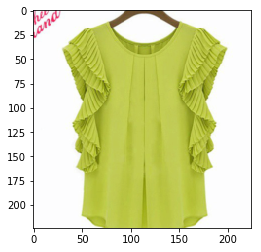

In [27]:
rnd1 = np.random.randint(len(train_dset))
im1, lbl1 = train_dset[rnd1]
imshow(tensor_to_numpy(im1, args.pretrain_dset_mean, args.pretrain_dset_std))
print(lbl1)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


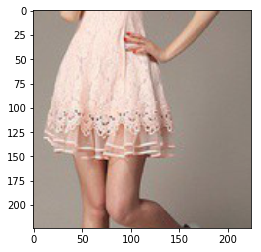

In [28]:
rnd2 = np.random.randint(len(val_dset))
im2, lbl2 = val_dset[rnd2]
imshow(tensor_to_numpy(im2, args.pretrain_dset_mean, args.pretrain_dset_std))
print(lbl2)

# DataLoader

In [29]:
if args.distributed:
    dist.init_process_group(backend=args.dist_backend,
                            init_method=args.dist_url,
                            world_size=args.world_size)


In [30]:
from torch.utils.data.distributed import DistributedSampler 


if args.distributed:
  train_sampler = DistributedSampler(train_dset)
else:
  train_sampler = None

train_loader = torch.utils.data.DataLoader(train_dset,
                                           batch_size=args.batch_size,
                                           shuffle=(train_sampler is None),
                                           num_workers=args.num_workers,
                                           pin_memory=True,
                                           sampler=train_sampler
                                          )

val_loader = torch.utils.data.DataLoader(val_dset,
                                         batch_size=args.batch_size,
                                         shuffle=False,
                                         num_workers=args.num_workers,
                                         pin_memory=True
                                        )


In [31]:
# train_images, train_labels = next(iter(train_loader))

In [32]:
# rnd11 = np.random.randint(args.batch_size)
# print(train_images[rnd11,:,:,:])
# print(train_labels[rnd11, :])

In [33]:
# val_images, val_labels = next(iter(val_loader))

In [34]:
# rnd21 = np.random.randint(args.batch_size)
# print(val_images[rnd21,:,:,:])
# print(val_labels[rnd21, :])


# Model

In [35]:
import torch.nn.init as weight_init


class FCWithLogSigmoid(nn.Module):
  
  def __init__(self, num_inputs, num_outputs):
    super(FCWithLogSigmoid, self).__init__()
    self.linear = nn.Linear(num_inputs, num_outputs)
    self.logsigmoid = nn.LogSigmoid()
    
  def forward(self, x):
    return self.logsigmoid(self.linear(x))


def create_model(arch, num_labels=228, fv_size=2048, pretrained=True, resume=False, distributed=False):
  if pretrained:
      print("=> using pre-trained model '{}'".format(arch))
      model = models.__dict__[arch](pretrained=True)
  else:
      print("=> creating model '{}'".format(arch))
      model = models.__dict__[arch]()
  model.fc = FCWithLogSigmoid(fv_size, num_labels)
  if not distributed:
      if arch.startswith('alexnet') or arch.startswith('vgg'):
          model.features = torch.nn.DataParallel(model.features)
          model.cuda()
      else:
          model = torch.nn.DataParallel(model).cuda()
  else:
      model.cuda()
      model = torch.nn.parallel.DistributedDataParallel(model)
  return model


In [36]:
def count_parameters(model):
  """source: https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/9"""
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [37]:
model = create_model(args.arch,
                     num_labels=args.num_labels,
                     fv_size=args.fv_size,
                     pretrained=args.pretrained,
                     resume=args.resume,
                     distributed=args.distributed)

=> using pre-trained model 'resnet101'


In [38]:
print("Neural Network has ", count_parameters(model), " trainable parameters")

Neural Network has  42967332  trainable parameters


In [39]:
class WeightUpdateTracker:
    
    def __init__(self, model):
        with torch.no_grad():
            self.num_param_tensors = len(list(model.parameters()))
            self.prev_pnorms = torch.zeros(self.num_param_tensors) 
            self.curr_pnorms = self.parameter_norms(model) 

    def parameter_norms(self, model):
        with torch.no_grad():
            pnorms = torch.zeros(self.num_param_tensors)
            for i, x in enumerate(list(model.parameters())):
                pnorms[i] = x.norm().item()
            return pnorms
        
    def track(self, model):
        with torch.no_grad():
            self.prev_pnorms = self.curr_pnorms.clone()
            self.curr_pnorms = self.parameter_norms(model)
            self.delta = (self.curr_pnorms - self.prev_pnorms) / self.prev_pnorms

            
    def __repr__(self):
        with torch.no_grad():
            return self.delta.__repr__()
        

# Loss Function


In [40]:
criterion = torch.nn.BCEWithLogitsLoss().cuda()

# Update Rule

In [41]:
optimizer = optim.Adam(model.parameters(),
                       amsgrad=True,
                       lr=args.optimizer_learning_rate,
                       betas=(0.9, 0.999),
                       eps=1e-8,
                       weight_decay=0.0
                      )
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                           mode='max',   # F1 measure
                                           patience=args.scheduler_patience,
                                           threshold=args.scheduler_threshold,
                                           factor=args.scheduler_factor,
                                           verbose=1
                                          )


# Training Loop


In [42]:
def load_checkpoint(model, optimizer, scheduler, args, resume=True, ckpt=None):
    """optionally resume from a checkpoint."""
    best_f1 = 0
    if args.resume:
        if os.path.isfile(ckpt):
            print("=> loading checkpoint '{}'".format(ckpt))
            checkpoint = torch.load(ckpt)
            args.start_epoch = checkpoint['epoch']
            best_f1 = checkpoint['best_f1']
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
          #  scheduler.load_state_dict(checkpoint['scheduler'])
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(args.resume, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(ckpt))
            best_f1 = 0
    return (model, optimizer, scheduler, args, best_f1)

In [43]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar', best_model_filename='model_best.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, best_model_filename)

In [44]:
class F1MicroAverageMeter(object):
    """Computes and stores F1 store"""
    def __init__(self, threshold=0.5, small=1e-12):
        self.threshold = threshold
        self.small = small
        self.reset()

    def reset(self):
        self.TP = 0.0
        self.FP = 0.0
        self.FN = 0.0
        self.TN = 0.0
        self.precision = 0.0
        self.recall = 0.0
        self.f1 = 0.0

    def update(self, labels, pred):
        tp, fp, fn, tn = self.confusion_matrix_(labels, pred)
        self.TP += tp
        self.FP += fp
        self.FN += fn
        self.TN += tn
        self.precision = self.TP / (self.small + self.TP + self.FP)
        self.recall = self.TP / (self.small + self.TP + self.FN)
        self.f1 = (2.0 * self.precision * self.recall) / (self.small + self.precision + self.recall)
        
    def confusion_matrix_(self, labels, pred):
        with torch.no_grad():
            real = labels
            fake = 1.0 - real
            pos = pred.ge(self.threshold).float()
            neg = 1.0 - pos
            tp = torch.sum(real * pos).item()
            fp = torch.sum(fake * pos).item()
            fn = torch.sum(real * neg).item()
            tn = torch.sum(fake * neg).item()
            return (tp, fp, fn, tn)
              

In [45]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [46]:
def adjust_learning_rate(optimizer, scheduler, epoch, measure, args):
    if not args.test_overfit:
        scheduler.step(measure)


In [47]:
def train(train_loader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    cmpoint5 = F1MicroAverageMeter(threshold=0.5)

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        target = target.cuda(non_blocking=True)

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # measure F1 and record loss
        losses.update(loss.item(), input.size(0))
        cmpoint5.update(target, torch.exp(output))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        
        

        if i % args.print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Precision {cmpoint5.precision:.3f}\t'
                  'Recall {cmpoint5.recall:.3f}\t'
                  'F1 {cmpoint5.f1:.3f}'.format(
                   epoch, i, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses, cmpoint5=cmpoint5))

In [48]:
def validate(val_loader, model, criterion):
    batch_time = AverageMeter()
    losses = AverageMeter()
    cmpoint5 = F1MicroAverageMeter(threshold=0.5)

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (input, target) in enumerate(val_loader):
            target = target.cuda(non_blocking=True)

            # compute output
            output = model(input)
            loss = criterion(output, target)

            # measure F1 and record loss
            losses.update(loss.item(), input.size(0))
            cmpoint5.update(target, torch.exp(output))
            
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % args.print_freq == 0:
                 print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Precision {cmpoint5.precision:.3f}\t'
                      'Recall {cmpoint5.recall:.3f}\t'
                      'F1 {cmpoint5.f1:.3f}'.format(
                       i, len(val_loader), batch_time=batch_time, loss=losses,
                       cmpoint5=cmpoint5))

        print(' * Precision {cmpoint5.precision:.3f} Recall {cmpoint5.recall:.3f} F1 {cmpoint5.f1:.3f}'
              .format(cmpoint5=cmpoint5))

    return cmpoint5.f1

In [ ]:
if args.evaluate:
    validate(val_loader, model, criterion)
else:
    model, optimizer, scheduler, args, best_f1 = load_checkpoint(model, optimizer, scheduler, args, resume=args.resume, ckpt=args.ckpt)
    wut = WeightUpdateTracker(model)
    for epoch in range(args.start_epoch, args.epochs):
        if args.distributed:
            train_sampler.set_epoch(epoch)
#         adjust_learning_rate(optimizer, epoch)

        # train for one epoch
        train(train_loader, model, criterion, optimizer, epoch)
        
        # debug: track weight updates
        wut.track(model)
        print(wut)
        
        # evaluate on validation set
        f1 = validate(val_loader, model, criterion)

        # remember best f1 and save checkpoint
        is_best = f1 > best_f1
        best_f1 = max(f1, best_f1)
        save_checkpoint({
            'epoch': epoch + 1,
            'arch': args.arch,
            'state_dict': model.state_dict(),
            'best_f1': best_f1,
            'optimizer' : optimizer.state_dict(),
           # 'scheduler' : scheduler.state_dict(),
        }, is_best, filename=args.ckpt, best_model_filename=args.best)
        
        adjust_learning_rate(optimizer, scheduler, epoch, f1, args)
        


Epoch: [0][0/8]	Time 7.007 (7.007)	Data 1.953 (1.953)	Loss 0.4229 (0.4229)	Precision 0.028	Recall 0.515	F1 0.054
tensor(1.00000e-03 *
       [-0.0059,  0.0117,  0.0257,  0.0067, -0.0200,  0.1494,  0.0708,
         0.0643, -0.0800,  0.0460,  0.0313, -0.6448,  0.0347,  0.0730,
        -0.6448, -0.0420,  0.4573, -0.6290,  0.0852,  1.0522, -1.3119,
         0.1305, -0.2920, -0.9018,  0.1108, -0.3010,  0.3551, -0.0346,
        -0.0128, -0.6174,  0.0695,  0.3957, -0.7161,  0.1184, -0.0933,
         0.4474,  0.1332, -0.0442,  0.0111,  0.0469, -0.0043,  0.1587,
         0.0578,  0.0738,  0.1587,  0.2999, -0.1639, -0.1301,  0.2359,
         0.1022, -0.0385,  0.1168, -0.0639, -0.1670,  0.1086,  0.0918,
        -0.1569,  0.2171, -0.0752,  0.0593,  0.0902,  0.1980, -0.0036,
         0.0885, -0.0720,  0.6206,  0.1387, -0.0569,  0.2689,  0.1513,
        -0.1638, -0.2023,  0.0728,  0.0111, -0.0917,  0.1750, -0.0127,
        -0.0091,  0.1201,  0.0812,  0.5837,  0.2135, -0.1376,  0.5837,
         1.081

Test: [0/619]	Time 1.994 (1.994)	Loss 0.2346 (0.2346)	Precision 0.568	Recall 0.158	F1 0.247
Test: [16/619]	Time 0.620 (0.486)	Loss 0.2294 (0.2330)	Precision 0.558	Recall 0.169	F1 0.259
Test: [32/619]	Time 0.561 (0.365)	Loss 0.2293 (0.2316)	Precision 0.562	Recall 0.174	F1 0.266
Test: [48/619]	Time 0.352 (0.311)	Loss 0.2311 (0.2318)	Precision 0.561	Recall 0.172	F1 0.263
Test: [64/619]	Time 0.273 (0.277)	Loss 0.2364 (0.2324)	Precision 0.556	Recall 0.169	F1 0.259
Test: [80/619]	Time 0.736 (0.261)	Loss 0.2319 (0.2325)	Precision 0.556	Recall 0.169	F1 0.259
Test: [96/619]	Time 0.175 (0.242)	Loss 0.2308 (0.2327)	Precision 0.554	Recall 0.168	F1 0.258
Test: [112/619]	Time 0.202 (0.226)	Loss 0.2310 (0.2327)	Precision 0.558	Recall 0.170	F1 0.260
Test: [128/619]	Time 0.226 (0.215)	Loss 0.2296 (0.2325)	Precision 0.559	Recall 0.170	F1 0.260
Test: [144/619]	Time 0.180 (0.205)	Loss 0.2369 (0.2325)	Precision 0.560	Recall 0.170	F1 0.260
Test: [160/619]	Time 0.462 (0.202)	Loss 0.2310 (0.2325)	Precision 0.

Test: [208/619]	Time 0.114 (0.149)	Loss 0.1681 (0.1586)	Precision 0.584	Recall 0.167	F1 0.260
Test: [224/619]	Time 0.099 (0.148)	Loss 0.1561 (0.1587)	Precision 0.583	Recall 0.167	F1 0.260
Test: [240/619]	Time 0.100 (0.146)	Loss 0.1604 (0.1587)	Precision 0.584	Recall 0.167	F1 0.260
Test: [256/619]	Time 0.101 (0.146)	Loss 0.1756 (0.1588)	Precision 0.583	Recall 0.167	F1 0.260
Test: [272/619]	Time 0.105 (0.145)	Loss 0.1662 (0.1590)	Precision 0.580	Recall 0.166	F1 0.258
Test: [288/619]	Time 0.099 (0.144)	Loss 0.1582 (0.1592)	Precision 0.577	Recall 0.165	F1 0.257
Test: [304/619]	Time 0.100 (0.144)	Loss 0.1678 (0.1593)	Precision 0.575	Recall 0.164	F1 0.255
Test: [320/619]	Time 0.100 (0.144)	Loss 0.1686 (0.1596)	Precision 0.573	Recall 0.163	F1 0.254
Test: [336/619]	Time 0.100 (0.143)	Loss 0.1662 (0.1598)	Precision 0.572	Recall 0.163	F1 0.253
Test: [352/619]	Time 0.099 (0.143)	Loss 0.1682 (0.1600)	Precision 0.571	Recall 0.162	F1 0.252
Test: [368/619]	Time 0.105 (0.142)	Loss 0.1569 (0.1601)	Prec

Test: [176/619]	Time 0.110 (0.151)	Loss 0.1255 (0.1269)	Precision 0.625	Recall 0.170	F1 0.267
Test: [192/619]	Time 0.100 (0.149)	Loss 0.1276 (0.1269)	Precision 0.624	Recall 0.170	F1 0.267
Test: [208/619]	Time 0.100 (0.148)	Loss 0.1410 (0.1270)	Precision 0.623	Recall 0.169	F1 0.266
Test: [224/619]	Time 0.216 (0.146)	Loss 0.1264 (0.1270)	Precision 0.623	Recall 0.169	F1 0.266
Test: [240/619]	Time 0.254 (0.145)	Loss 0.1276 (0.1270)	Precision 0.623	Recall 0.169	F1 0.266
Test: [256/619]	Time 0.200 (0.144)	Loss 0.1483 (0.1272)	Precision 0.623	Recall 0.169	F1 0.266
Test: [272/619]	Time 0.225 (0.143)	Loss 0.1359 (0.1275)	Precision 0.621	Recall 0.168	F1 0.264
Test: [288/619]	Time 0.205 (0.143)	Loss 0.1249 (0.1276)	Precision 0.617	Recall 0.167	F1 0.263
Test: [304/619]	Time 0.246 (0.142)	Loss 0.1392 (0.1279)	Precision 0.614	Recall 0.166	F1 0.262
Test: [320/619]	Time 0.143 (0.141)	Loss 0.1398 (0.1282)	Precision 0.612	Recall 0.165	F1 0.260
Test: [336/619]	Time 0.162 (0.141)	Loss 0.1369 (0.1285)	Prec

Test: [384/619]	Time 0.099 (0.149)	Loss 0.1207 (0.1192)	Precision 0.649	Recall 0.162	F1 0.259
Test: [400/619]	Time 0.106 (0.148)	Loss 0.1205 (0.1192)	Precision 0.648	Recall 0.162	F1 0.259
Test: [416/619]	Time 0.100 (0.148)	Loss 0.1266 (0.1193)	Precision 0.647	Recall 0.162	F1 0.259
Test: [432/619]	Time 0.100 (0.147)	Loss 0.1223 (0.1193)	Precision 0.647	Recall 0.162	F1 0.259
Test: [448/619]	Time 0.105 (0.147)	Loss 0.1315 (0.1195)	Precision 0.645	Recall 0.161	F1 0.258
Test: [464/619]	Time 0.106 (0.147)	Loss 0.1240 (0.1196)	Precision 0.643	Recall 0.160	F1 0.257
Test: [480/619]	Time 0.102 (0.146)	Loss 0.1214 (0.1196)	Precision 0.643	Recall 0.160	F1 0.256
Test: [496/619]	Time 0.100 (0.146)	Loss 0.1095 (0.1196)	Precision 0.642	Recall 0.160	F1 0.256
Test: [512/619]	Time 0.100 (0.145)	Loss 0.1230 (0.1197)	Precision 0.642	Recall 0.160	F1 0.256
Test: [528/619]	Time 0.099 (0.145)	Loss 0.1190 (0.1197)	Precision 0.642	Recall 0.160	F1 0.256
Test: [544/619]	Time 0.100 (0.145)	Loss 0.1194 (0.1198)	Prec

Test: [592/619]	Time 0.102 (0.139)	Loss 0.1320 (0.1165)	Precision 0.633	Recall 0.168	F1 0.265
Test: [608/619]	Time 0.100 (0.139)	Loss 0.1199 (0.1166)	Precision 0.633	Recall 0.167	F1 0.265
 * Precision 0.632 Recall 0.167 F1 0.265
Epoch: [6][0/8]	Time 2.031 (2.031)	Data 1.679 (1.679)	Loss 0.0588 (0.0588)	Precision 0.722	Recall 0.321	F1 0.444
tensor([ 2.2527e-06, -2.0724e-05, -4.4877e-05,  5.0574e-06,  4.2056e-05,
        -6.8855e-05,  2.9082e-05,  4.6867e-05, -7.0669e-05,  3.1106e-05,
         2.7774e-05,  2.1847e-05,  1.5823e-05,  1.1226e-05,  2.1847e-05,
         4.8110e-05, -1.2575e-05,  2.0107e-05,  2.0744e-06, -7.8684e-05,
         2.2717e-04,  6.4023e-05, -3.3874e-05, -1.0865e-05,  3.8235e-05,
         8.9803e-05, -9.2895e-05,  4.1239e-05, -3.1509e-06,  1.0406e-04,
         4.8548e-05, -7.6090e-05, -2.0005e-04,  4.1047e-05, -5.2881e-06,
         6.6508e-05,  5.6060e-05,  2.4963e-05, -1.6569e-04,  3.5287e-05,
        -1.5433e-05,  1.0231e-04,  4.4891e-05,  1.0414e-05,  1.0231e-04,
 

Test: [560/619]	Time 0.100 (0.136)	Loss 0.1117 (0.1144)	Precision 0.648	Recall 0.174	F1 0.275
Test: [576/619]	Time 0.101 (0.136)	Loss 0.1147 (0.1145)	Precision 0.648	Recall 0.174	F1 0.274
Test: [592/619]	Time 0.101 (0.136)	Loss 0.1308 (0.1145)	Precision 0.648	Recall 0.174	F1 0.274
Test: [608/619]	Time 0.101 (0.136)	Loss 0.1188 (0.1146)	Precision 0.648	Recall 0.174	F1 0.274
 * Precision 0.647 Recall 0.174 F1 0.274
Epoch: [7][0/8]	Time 1.595 (1.595)	Data 1.226 (1.226)	Loss 0.0526 (0.0526)	Precision 0.824	Recall 0.506	F1 0.627
tensor(1.00000e-03 *
       [ 0.0020, -0.0094,  0.0019,  0.0159,  0.0308, -0.0640,  0.0154,
         0.0539, -0.0360,  0.0169, -0.0441, -0.0203,  0.0236,  0.0768,
        -0.0203,  0.0420, -0.0401,  0.0575, -0.0160, -0.0096, -0.0063,
         0.0776, -0.0897, -0.0788,  0.0300,  0.0497, -0.1143,  0.0208,
        -0.0074, -0.0004,  0.0295, -0.0954, -0.1045,  0.0147, -0.0062,
         0.0520,  0.0431, -0.0077, -0.0342,  0.0231, -0.0218,  0.0886,
         0.0453, -0.005

Test: [0/619]	Time 1.171 (1.171)	Loss 0.1139 (0.1139)	Precision 0.828	Recall 0.180	F1 0.296
Test: [16/619]	Time 0.364 (0.240)	Loss 0.0948 (0.1099)	Precision 0.685	Recall 0.186	F1 0.292
Test: [32/619]	Time 0.383 (0.202)	Loss 0.0979 (0.1088)	Precision 0.693	Recall 0.191	F1 0.300
Test: [48/619]	Time 0.326 (0.190)	Loss 0.1107 (0.1102)	Precision 0.703	Recall 0.191	F1 0.300
Test: [64/619]	Time 0.099 (0.182)	Loss 0.1052 (0.1112)	Precision 0.694	Recall 0.186	F1 0.293
Test: [80/619]	Time 0.199 (0.174)	Loss 0.1121 (0.1115)	Precision 0.697	Recall 0.187	F1 0.294
Test: [96/619]	Time 0.103 (0.168)	Loss 0.1116 (0.1115)	Precision 0.700	Recall 0.186	F1 0.294
Test: [112/619]	Time 0.103 (0.167)	Loss 0.1127 (0.1116)	Precision 0.706	Recall 0.187	F1 0.296
Test: [128/619]	Time 0.103 (0.167)	Loss 0.1057 (0.1112)	Precision 0.705	Recall 0.186	F1 0.294
Test: [144/619]	Time 0.100 (0.167)	Loss 0.1138 (0.1113)	Precision 0.704	Recall 0.186	F1 0.294
Test: [160/619]	Time 0.101 (0.168)	Loss 0.1036 (0.1110)	Precision 0.

Test: [208/619]	Time 0.100 (0.160)	Loss 0.1245 (0.1108)	Precision 0.713	Recall 0.188	F1 0.297
Test: [224/619]	Time 0.101 (0.157)	Loss 0.1090 (0.1108)	Precision 0.710	Recall 0.188	F1 0.297
Test: [240/619]	Time 0.101 (0.155)	Loss 0.1140 (0.1108)	Precision 0.710	Recall 0.187	F1 0.296
Test: [256/619]	Time 0.110 (0.154)	Loss 0.1370 (0.1110)	Precision 0.711	Recall 0.187	F1 0.297
Test: [272/619]	Time 0.100 (0.155)	Loss 0.1266 (0.1114)	Precision 0.709	Recall 0.186	F1 0.295
Test: [288/619]	Time 0.100 (0.155)	Loss 0.1113 (0.1116)	Precision 0.705	Recall 0.185	F1 0.293
Test: [304/619]	Time 0.107 (0.155)	Loss 0.1266 (0.1120)	Precision 0.702	Recall 0.185	F1 0.292
Test: [320/619]	Time 0.116 (0.154)	Loss 0.1261 (0.1122)	Precision 0.700	Recall 0.183	F1 0.291
Test: [336/619]	Time 0.106 (0.154)	Loss 0.1231 (0.1127)	Precision 0.697	Recall 0.182	F1 0.289
Test: [352/619]	Time 0.100 (0.154)	Loss 0.1240 (0.1130)	Precision 0.696	Recall 0.182	F1 0.288
Test: [368/619]	Time 0.100 (0.153)	Loss 0.1083 (0.1130)	Prec

Test: [416/619]	Time 0.100 (0.154)	Loss 0.1206 (0.1134)	Precision 0.714	Recall 0.177	F1 0.283
Test: [432/619]	Time 0.100 (0.154)	Loss 0.1159 (0.1134)	Precision 0.714	Recall 0.176	F1 0.283
Test: [448/619]	Time 0.101 (0.153)	Loss 0.1287 (0.1136)	Precision 0.713	Recall 0.176	F1 0.282
Test: [464/619]	Time 0.100 (0.153)	Loss 0.1169 (0.1138)	Precision 0.711	Recall 0.175	F1 0.281
Test: [480/619]	Time 0.099 (0.152)	Loss 0.1164 (0.1138)	Precision 0.710	Recall 0.175	F1 0.280
Test: [496/619]	Time 0.099 (0.152)	Loss 0.1036 (0.1138)	Precision 0.709	Recall 0.175	F1 0.280
Test: [512/619]	Time 0.100 (0.151)	Loss 0.1163 (0.1139)	Precision 0.709	Recall 0.174	F1 0.280
Test: [528/619]	Time 0.111 (0.151)	Loss 0.1112 (0.1139)	Precision 0.709	Recall 0.174	F1 0.280
Test: [544/619]	Time 0.106 (0.151)	Loss 0.1177 (0.1140)	Precision 0.709	Recall 0.174	F1 0.279
Test: [560/619]	Time 0.099 (0.150)	Loss 0.1129 (0.1140)	Precision 0.708	Recall 0.174	F1 0.279
Test: [576/619]	Time 0.106 (0.150)	Loss 0.1122 (0.1141)	Prec

Test: [384/619]	Time 0.099 (0.147)	Loss 0.1164 (0.1137)	Precision 0.724	Recall 0.176	F1 0.283
Test: [400/619]	Time 0.100 (0.146)	Loss 0.1160 (0.1137)	Precision 0.723	Recall 0.176	F1 0.283
Test: [416/619]	Time 0.105 (0.146)	Loss 0.1207 (0.1138)	Precision 0.722	Recall 0.175	F1 0.282
Test: [432/619]	Time 0.099 (0.146)	Loss 0.1163 (0.1139)	Precision 0.721	Recall 0.175	F1 0.282
Test: [448/619]	Time 0.100 (0.145)	Loss 0.1296 (0.1141)	Precision 0.721	Recall 0.175	F1 0.281
Test: [464/619]	Time 0.102 (0.145)	Loss 0.1181 (0.1143)	Precision 0.719	Recall 0.174	F1 0.280
Test: [480/619]	Time 0.100 (0.145)	Loss 0.1161 (0.1143)	Precision 0.718	Recall 0.174	F1 0.280
Test: [496/619]	Time 0.100 (0.144)	Loss 0.1041 (0.1142)	Precision 0.717	Recall 0.173	F1 0.279
Test: [512/619]	Time 0.099 (0.144)	Loss 0.1161 (0.1143)	Precision 0.717	Recall 0.173	F1 0.279
Test: [528/619]	Time 0.188 (0.143)	Loss 0.1116 (0.1144)	Precision 0.717	Recall 0.173	F1 0.279
Test: [544/619]	Time 0.288 (0.144)	Loss 0.1182 (0.1144)	Prec

Test: [592/619]	Time 0.107 (0.146)	Loss 0.1346 (0.1154)	Precision 0.722	Recall 0.175	F1 0.282
Test: [608/619]	Time 0.100 (0.146)	Loss 0.1201 (0.1155)	Precision 0.722	Recall 0.175	F1 0.282
 * Precision 0.722 Recall 0.175 F1 0.281
Epoch: [13][0/8]	Time 2.687 (2.687)	Data 2.340 (2.340)	Loss 0.0387 (0.0387)	Precision 0.972	Recall 0.704	F1 0.817
tensor(1.00000e-03 *
       [-0.0015, -0.0031,  0.0334,  0.0230,  0.0238, -0.0035,  0.0001,
        -0.0449, -0.0208,  0.0275,  0.0224,  0.0430,  0.0284, -0.0148,
         0.0430,  0.0195, -0.1191,  0.0833, -0.0456, -0.0050,  0.0520,
         0.0086, -0.0717,  0.2232,  0.0115, -0.0254,  0.1409,  0.0071,
         0.0011,  0.0716,  0.0233,  0.0178,  0.2256,  0.0118, -0.0321,
         0.0668,  0.0170,  0.0170, -0.0800,  0.0085,  0.0192,  0.1940,
         0.0169, -0.0162,  0.1940,  0.1220, -0.1508,  0.0241,  0.0127,
         0.0224, -0.0155,  0.0512, -0.0094, -0.0348,  0.0207, -0.0500,
         0.2522,  0.0302, -0.0078, -0.0920,  0.0358, -0.0719, -0.013

Test: [0/619]	Time 1.196 (1.196)	Loss 0.1171 (0.1171)	Precision 0.800	Recall 0.180	F1 0.294
Test: [16/619]	Time 0.308 (0.236)	Loss 0.0950 (0.1115)	Precision 0.721	Recall 0.184	F1 0.293
Test: [32/619]	Time 0.447 (0.209)	Loss 0.0976 (0.1105)	Precision 0.722	Recall 0.189	F1 0.300
Test: [48/619]	Time 0.243 (0.204)	Loss 0.1108 (0.1120)	Precision 0.733	Recall 0.188	F1 0.300
Test: [64/619]	Time 0.099 (0.199)	Loss 0.1067 (0.1131)	Precision 0.725	Recall 0.184	F1 0.294
Test: [80/619]	Time 0.103 (0.189)	Loss 0.1120 (0.1134)	Precision 0.728	Recall 0.186	F1 0.296
Test: [96/619]	Time 0.100 (0.181)	Loss 0.1126 (0.1135)	Precision 0.729	Recall 0.185	F1 0.295
Test: [112/619]	Time 0.100 (0.174)	Loss 0.1146 (0.1135)	Precision 0.735	Recall 0.186	F1 0.297
Test: [128/619]	Time 0.100 (0.169)	Loss 0.1083 (0.1131)	Precision 0.734	Recall 0.186	F1 0.296
Test: [144/619]	Time 0.099 (0.166)	Loss 0.1170 (0.1132)	Precision 0.732	Recall 0.185	F1 0.295
Test: [160/619]	Time 0.105 (0.163)	Loss 0.1034 (0.1130)	Precision 0.

Test: [208/619]	Time 0.099 (0.154)	Loss 0.1251 (0.1129)	Precision 0.739	Recall 0.186	F1 0.298
Test: [224/619]	Time 0.171 (0.155)	Loss 0.1114 (0.1128)	Precision 0.737	Recall 0.186	F1 0.297
Test: [240/619]	Time 0.113 (0.155)	Loss 0.1169 (0.1129)	Precision 0.738	Recall 0.186	F1 0.297
Test: [256/619]	Time 0.245 (0.154)	Loss 0.1415 (0.1130)	Precision 0.738	Recall 0.186	F1 0.297
Test: [272/619]	Time 0.165 (0.153)	Loss 0.1327 (0.1135)	Precision 0.737	Recall 0.185	F1 0.295
Test: [288/619]	Time 0.225 (0.153)	Loss 0.1143 (0.1138)	Precision 0.733	Recall 0.183	F1 0.293
Test: [304/619]	Time 0.257 (0.153)	Loss 0.1284 (0.1141)	Precision 0.732	Recall 0.183	F1 0.292
Test: [320/619]	Time 0.228 (0.152)	Loss 0.1282 (0.1144)	Precision 0.730	Recall 0.181	F1 0.290
Test: [336/619]	Time 0.229 (0.152)	Loss 0.1252 (0.1149)	Precision 0.729	Recall 0.180	F1 0.289
Test: [352/619]	Time 0.358 (0.151)	Loss 0.1254 (0.1152)	Precision 0.727	Recall 0.180	F1 0.288
Test: [368/619]	Time 0.201 (0.151)	Loss 0.1095 (0.1152)	Prec

Test: [416/619]	Time 0.103 (0.170)	Loss 0.1226 (0.1160)	Precision 0.720	Recall 0.180	F1 0.288
Test: [432/619]	Time 0.104 (0.169)	Loss 0.1186 (0.1161)	Precision 0.718	Recall 0.180	F1 0.288
Test: [448/619]	Time 0.117 (0.169)	Loss 0.1330 (0.1163)	Precision 0.717	Recall 0.179	F1 0.287
Test: [464/619]	Time 0.100 (0.169)	Loss 0.1185 (0.1165)	Precision 0.716	Recall 0.179	F1 0.286
Test: [480/619]	Time 0.099 (0.168)	Loss 0.1189 (0.1165)	Precision 0.716	Recall 0.179	F1 0.286
Test: [496/619]	Time 0.099 (0.168)	Loss 0.1059 (0.1164)	Precision 0.715	Recall 0.178	F1 0.285
Test: [512/619]	Time 0.105 (0.167)	Loss 0.1177 (0.1165)	Precision 0.715	Recall 0.178	F1 0.285
Test: [528/619]	Time 0.100 (0.167)	Loss 0.1122 (0.1166)	Precision 0.715	Recall 0.178	F1 0.285
Test: [544/619]	Time 0.099 (0.166)	Loss 0.1216 (0.1167)	Precision 0.715	Recall 0.178	F1 0.284
Test: [560/619]	Time 0.099 (0.166)	Loss 0.1150 (0.1167)	Precision 0.713	Recall 0.177	F1 0.284
Test: [576/619]	Time 0.102 (0.166)	Loss 0.1150 (0.1168)	Prec

 * Precision 0.699 Recall 0.176 F1 0.281
Epoch: [18][0/8]	Time 3.123 (3.123)	Data 2.776 (2.776)	Loss 0.0295 (0.0295)	Precision 0.987	Recall 0.868	F1 0.924
tensor(1.00000e-03 *
       [ 0.0010,  0.0146,  0.0033,  0.0341,  0.0245, -0.0386,  0.0027,
         0.0546, -0.0108,  0.0129, -0.0573, -0.0478,  0.0175,  0.0256,
        -0.0478, -0.0054, -0.0248,  0.0135,  0.0099, -0.1374,  0.2003,
        -0.0128, -0.0059, -0.0569,  0.0299, -0.0208,  0.0231,  0.0102,
         0.0022,  0.0716,  0.0227,  0.0472,  0.1843,  0.0167,  0.0035,
        -0.0374,  0.0198, -0.0094, -0.0190,  0.0069,  0.0550, -0.0641,
         0.0255, -0.0178, -0.0641,  0.0614,  0.0283, -0.0655,  0.0447,
         0.0002,  0.1487,  0.0485, -0.0140, -0.0970,  0.0204, -0.0218,
         0.0360,  0.0233, -0.0087,  0.0460,  0.0183,  0.0193, -0.0395,
         0.0128,  0.0250, -0.2092,  0.0232,  0.0043, -0.0570,  0.0207,
         0.0211, -0.0363,  0.0204,  0.0162, -0.0736,  0.0426,  0.0229,
        -0.0710,  0.0252, -0.0935, -0.0890,

Test: [0/619]	Time 1.561 (1.561)	Loss 0.1182 (0.1182)	Precision 0.774	Recall 0.180	F1 0.293
Test: [16/619]	Time 0.389 (0.271)	Loss 0.0962 (0.1137)	Precision 0.712	Recall 0.189	F1 0.298
Test: [32/619]	Time 0.532 (0.223)	Loss 0.0983 (0.1127)	Precision 0.710	Recall 0.193	F1 0.303
Test: [48/619]	Time 0.229 (0.204)	Loss 0.1124 (0.1143)	Precision 0.724	Recall 0.194	F1 0.307
Test: [64/619]	Time 0.099 (0.192)	Loss 0.1095 (0.1155)	Precision 0.714	Recall 0.192	F1 0.302
Test: [80/619]	Time 0.120 (0.178)	Loss 0.1141 (0.1157)	Precision 0.718	Recall 0.193	F1 0.305
Test: [96/619]	Time 0.100 (0.172)	Loss 0.1150 (0.1158)	Precision 0.717	Recall 0.193	F1 0.304
Test: [112/619]	Time 0.105 (0.165)	Loss 0.1179 (0.1158)	Precision 0.721	Recall 0.193	F1 0.305
Test: [128/619]	Time 0.117 (0.159)	Loss 0.1107 (0.1154)	Precision 0.720	Recall 0.193	F1 0.305
Test: [144/619]	Time 0.100 (0.157)	Loss 0.1193 (0.1156)	Precision 0.719	Recall 0.192	F1 0.303
Test: [160/619]	Time 0.140 (0.153)	Loss 0.1050 (0.1153)	Precision 0.

Test: [208/619]	Time 0.325 (0.143)	Loss 0.1280 (0.1154)	Precision 0.720	Recall 0.191	F1 0.302
Test: [224/619]	Time 0.255 (0.143)	Loss 0.1132 (0.1154)	Precision 0.720	Recall 0.191	F1 0.301
Test: [240/619]	Time 0.229 (0.141)	Loss 0.1194 (0.1155)	Precision 0.720	Recall 0.190	F1 0.301
Test: [256/619]	Time 0.229 (0.141)	Loss 0.1455 (0.1156)	Precision 0.721	Recall 0.190	F1 0.301
Test: [272/619]	Time 0.183 (0.141)	Loss 0.1370 (0.1161)	Precision 0.720	Recall 0.189	F1 0.299
Test: [288/619]	Time 0.186 (0.140)	Loss 0.1167 (0.1164)	Precision 0.717	Recall 0.188	F1 0.297
Test: [304/619]	Time 0.208 (0.140)	Loss 0.1321 (0.1168)	Precision 0.717	Recall 0.187	F1 0.297
Test: [320/619]	Time 0.209 (0.140)	Loss 0.1314 (0.1171)	Precision 0.715	Recall 0.186	F1 0.295
Test: [336/619]	Time 0.233 (0.141)	Loss 0.1276 (0.1176)	Precision 0.714	Recall 0.185	F1 0.294
Test: [352/619]	Time 0.190 (0.140)	Loss 0.1291 (0.1179)	Precision 0.713	Recall 0.184	F1 0.293
Test: [368/619]	Time 0.378 (0.140)	Loss 0.1122 (0.1180)	Prec

Test: [176/619]	Time 0.099 (0.150)	Loss 0.1177 (0.1148)	Precision 0.725	Recall 0.196	F1 0.309
Test: [192/619]	Time 0.100 (0.149)	Loss 0.1168 (0.1147)	Precision 0.726	Recall 0.196	F1 0.309
Test: [208/619]	Time 0.099 (0.147)	Loss 0.1278 (0.1148)	Precision 0.726	Recall 0.197	F1 0.309
Test: [224/619]	Time 0.099 (0.147)	Loss 0.1125 (0.1147)	Precision 0.725	Recall 0.197	F1 0.309
Test: [240/619]	Time 0.100 (0.145)	Loss 0.1186 (0.1148)	Precision 0.725	Recall 0.196	F1 0.309
Test: [256/619]	Time 0.108 (0.145)	Loss 0.1451 (0.1149)	Precision 0.725	Recall 0.196	F1 0.309
Test: [272/619]	Time 0.100 (0.144)	Loss 0.1368 (0.1154)	Precision 0.725	Recall 0.195	F1 0.308
Test: [288/619]	Time 0.102 (0.144)	Loss 0.1150 (0.1157)	Precision 0.721	Recall 0.194	F1 0.306
Test: [304/619]	Time 0.100 (0.144)	Loss 0.1314 (0.1160)	Precision 0.720	Recall 0.194	F1 0.305
Test: [320/619]	Time 0.108 (0.143)	Loss 0.1314 (0.1164)	Precision 0.719	Recall 0.192	F1 0.304
Test: [336/619]	Time 0.113 (0.144)	Loss 0.1267 (0.1169)	Prec

Test: [384/619]	Time 0.100 (0.153)	Loss 0.1210 (0.1186)	Precision 0.711	Recall 0.189	F1 0.298
Test: [400/619]	Time 0.100 (0.152)	Loss 0.1203 (0.1186)	Precision 0.710	Recall 0.189	F1 0.298
Test: [416/619]	Time 0.107 (0.152)	Loss 0.1266 (0.1187)	Precision 0.709	Recall 0.188	F1 0.298
Test: [432/619]	Time 0.099 (0.151)	Loss 0.1219 (0.1187)	Precision 0.708	Recall 0.188	F1 0.297
Test: [448/619]	Time 0.101 (0.151)	Loss 0.1379 (0.1190)	Precision 0.708	Recall 0.188	F1 0.297
Test: [464/619]	Time 0.102 (0.151)	Loss 0.1215 (0.1192)	Precision 0.706	Recall 0.187	F1 0.295
Test: [480/619]	Time 0.107 (0.150)	Loss 0.1223 (0.1192)	Precision 0.706	Recall 0.187	F1 0.295
Test: [496/619]	Time 0.101 (0.150)	Loss 0.1071 (0.1192)	Precision 0.705	Recall 0.186	F1 0.295
Test: [512/619]	Time 0.106 (0.150)	Loss 0.1202 (0.1193)	Precision 0.705	Recall 0.186	F1 0.294
Test: [528/619]	Time 0.100 (0.149)	Loss 0.1150 (0.1193)	Precision 0.705	Recall 0.186	F1 0.294
Test: [544/619]	Time 0.109 (0.149)	Loss 0.1249 (0.1194)	Prec

Test: [592/619]	Time 0.100 (0.156)	Loss 0.1432 (0.1209)	Precision 0.689	Recall 0.181	F1 0.287
Test: [608/619]	Time 0.100 (0.156)	Loss 0.1278 (0.1210)	Precision 0.689	Recall 0.181	F1 0.287
 * Precision 0.689 Recall 0.181 F1 0.287
Epoch: [24][0/8]	Time 2.897 (2.897)	Data 2.555 (2.555)	Loss 0.0286 (0.0286)	Precision 1.000	Recall 0.971	F1 0.985
tensor(1.00000e-03 *
       [ 0.0003, -0.0035, -0.0244,  0.0298,  0.0316, -0.0820,  0.0099,
         0.0275, -0.0034,  0.0035, -0.0363, -0.0801,  0.0109,  0.0391,
        -0.0801,  0.0197, -0.1015,  0.0824, -0.0128, -0.0179,  0.0123,
         0.0353,  0.0139, -0.1193,  0.0274,  0.0624, -0.1587,  0.0188,
        -0.0098,  0.0689,  0.0201,  0.0506, -0.0963,  0.0082,  0.0013,
        -0.0181,  0.0165, -0.0014, -0.1020,  0.0073,  0.0163, -0.0493,
         0.0153,  0.0031, -0.0493,  0.0196, -0.1738,  0.1662,  0.0066,
         0.0058,  0.0493,  0.0289,  0.0581, -0.1131,  0.0067, -0.0147,
         0.1223,  0.0234, -0.0163,  0.1259,  0.0236,  0.0071, -0.048

Test: [0/619]	Time 1.310 (1.310)	Loss 0.1206 (0.1206)	Precision 0.735	Recall 0.188	F1 0.299
Test: [16/619]	Time 0.512 (0.250)	Loss 0.0981 (0.1161)	Precision 0.701	Recall 0.196	F1 0.307
Test: [32/619]	Time 0.260 (0.206)	Loss 0.0990 (0.1151)	Precision 0.700	Recall 0.199	F1 0.310
Test: [48/619]	Time 0.411 (0.195)	Loss 0.1152 (0.1168)	Precision 0.714	Recall 0.199	F1 0.311
Test: [64/619]	Time 0.220 (0.186)	Loss 0.1117 (0.1180)	Precision 0.704	Recall 0.194	F1 0.305
Test: [80/619]	Time 0.330 (0.178)	Loss 0.1155 (0.1182)	Precision 0.706	Recall 0.195	F1 0.305
Test: [96/619]	Time 0.110 (0.170)	Loss 0.1171 (0.1183)	Precision 0.704	Recall 0.194	F1 0.304
Test: [112/619]	Time 0.100 (0.173)	Loss 0.1211 (0.1184)	Precision 0.708	Recall 0.195	F1 0.306
Test: [128/619]	Time 0.107 (0.168)	Loss 0.1135 (0.1180)	Precision 0.706	Recall 0.195	F1 0.305
Test: [144/619]	Time 0.098 (0.165)	Loss 0.1241 (0.1181)	Precision 0.705	Recall 0.194	F1 0.304
Test: [160/619]	Time 0.105 (0.165)	Loss 0.1071 (0.1179)	Precision 0.

Test: [208/619]	Time 0.597 (0.153)	Loss 0.1318 (0.1181)	Precision 0.706	Recall 0.197	F1 0.308
Test: [224/619]	Time 0.288 (0.152)	Loss 0.1145 (0.1180)	Precision 0.705	Recall 0.197	F1 0.308
Test: [240/619]	Time 0.219 (0.151)	Loss 0.1229 (0.1181)	Precision 0.706	Recall 0.196	F1 0.307
Test: [256/619]	Time 0.205 (0.150)	Loss 0.1512 (0.1183)	Precision 0.707	Recall 0.196	F1 0.307
Test: [272/619]	Time 0.260 (0.149)	Loss 0.1419 (0.1188)	Precision 0.708	Recall 0.195	F1 0.306
Test: [288/619]	Time 0.125 (0.149)	Loss 0.1197 (0.1191)	Precision 0.704	Recall 0.194	F1 0.304
Test: [304/619]	Time 0.100 (0.148)	Loss 0.1354 (0.1194)	Precision 0.703	Recall 0.194	F1 0.304
Test: [320/619]	Time 0.100 (0.147)	Loss 0.1360 (0.1198)	Precision 0.702	Recall 0.193	F1 0.302
Test: [336/619]	Time 0.100 (0.147)	Loss 0.1310 (0.1203)	Precision 0.700	Recall 0.191	F1 0.301
Test: [352/619]	Time 0.099 (0.147)	Loss 0.1314 (0.1207)	Precision 0.700	Recall 0.191	F1 0.300
Test: [368/619]	Time 0.100 (0.147)	Loss 0.1143 (0.1207)	Prec

Test: [416/619]	Time 0.101 (0.153)	Loss 0.1302 (0.1211)	Precision 0.687	Recall 0.192	F1 0.300
Test: [432/619]	Time 0.106 (0.153)	Loss 0.1241 (0.1212)	Precision 0.686	Recall 0.192	F1 0.300
Test: [448/619]	Time 0.104 (0.153)	Loss 0.1403 (0.1214)	Precision 0.685	Recall 0.192	F1 0.299
Test: [464/619]	Time 0.100 (0.153)	Loss 0.1222 (0.1216)	Precision 0.684	Recall 0.191	F1 0.298
Test: [480/619]	Time 0.100 (0.153)	Loss 0.1250 (0.1217)	Precision 0.683	Recall 0.191	F1 0.298
Test: [496/619]	Time 0.107 (0.153)	Loss 0.1092 (0.1216)	Precision 0.683	Recall 0.191	F1 0.298
Test: [512/619]	Time 0.099 (0.153)	Loss 0.1239 (0.1217)	Precision 0.683	Recall 0.190	F1 0.297
Test: [528/619]	Time 0.101 (0.154)	Loss 0.1169 (0.1218)	Precision 0.683	Recall 0.190	F1 0.297
Test: [544/619]	Time 0.112 (0.155)	Loss 0.1278 (0.1219)	Precision 0.683	Recall 0.190	F1 0.297
Test: [560/619]	Time 0.108 (0.155)	Loss 0.1206 (0.1219)	Precision 0.682	Recall 0.189	F1 0.296
Test: [576/619]	Time 0.099 (0.154)	Loss 0.1191 (0.1220)	Prec

 * Precision 0.687 Recall 0.185 F1 0.291
Epoch: [29][0/8]	Time 4.035 (4.035)	Data 3.685 (3.685)	Loss 0.0237 (0.0237)	Precision 1.000	Recall 1.000	F1 1.000
tensor(1.00000e-03 *
       [-0.0015,  0.0066,  0.0454, -0.0082, -0.0420,  0.1082, -0.0161,
         0.0006, -0.0533,  0.0185, -0.0365,  0.0351,  0.0116,  0.0275,
         0.0351,  0.0111, -0.0479,  0.0462, -0.0384, -0.0449,  0.0304,
         0.0097,  0.0057,  0.0957,  0.0254, -0.1111,  0.2456, -0.0023,
        -0.0179, -0.0598, -0.0007, -0.0704,  0.0343,  0.0131, -0.0257,
         0.0852,  0.0069,  0.0053,  0.0044,  0.0091,  0.0393, -0.0056,
         0.0116, -0.0326, -0.0056,  0.0185, -0.1368,  0.0224,  0.0173,
         0.0176, -0.0774,  0.0419,  0.0207,  0.0509,  0.0283, -0.0325,
         0.1530,  0.0251, -0.0252,  0.1067,  0.0101,  0.0168,  0.0240,
         0.0149, -0.0074,  0.0456,  0.0195, -0.0041,  0.0393,  0.0151,
        -0.0499,  0.0391,  0.0135,  0.0067, -0.0206,  0.0306, -0.0049,
         0.0041,  0.0188, -0.0113, -0.0060,

Test: [0/619]	Time 1.114 (1.114)	Loss 0.1248 (0.1248)	Precision 0.714	Recall 0.188	F1 0.298
Test: [16/619]	Time 0.388 (0.230)	Loss 0.0987 (0.1186)	Precision 0.703	Recall 0.195	F1 0.306
Test: [32/619]	Time 0.401 (0.195)	Loss 0.1017 (0.1175)	Precision 0.701	Recall 0.196	F1 0.307
Test: [48/619]	Time 0.301 (0.185)	Loss 0.1175 (0.1193)	Precision 0.706	Recall 0.197	F1 0.308
Test: [64/619]	Time 0.099 (0.176)	Loss 0.1148 (0.1207)	Precision 0.696	Recall 0.193	F1 0.302
Test: [80/619]	Time 0.105 (0.166)	Loss 0.1183 (0.1209)	Precision 0.699	Recall 0.193	F1 0.303
Test: [96/619]	Time 0.100 (0.159)	Loss 0.1207 (0.1210)	Precision 0.698	Recall 0.193	F1 0.302
Test: [112/619]	Time 0.099 (0.156)	Loss 0.1237 (0.1211)	Precision 0.702	Recall 0.194	F1 0.304
Test: [128/619]	Time 0.099 (0.154)	Loss 0.1156 (0.1206)	Precision 0.704	Recall 0.194	F1 0.304
Test: [144/619]	Time 0.099 (0.151)	Loss 0.1263 (0.1208)	Precision 0.702	Recall 0.193	F1 0.303
Test: [160/619]	Time 0.100 (0.150)	Loss 0.1084 (0.1205)	Precision 0.

Test: [0/619]	Time 1.257 (1.257)	Loss 0.1249 (0.1249)	Precision 0.758	Recall 0.188	F1 0.301
Test: [16/619]	Time 0.547 (0.240)	Loss 0.1004 (0.1191)	Precision 0.712	Recall 0.193	F1 0.304
Test: [32/619]	Time 1.395 (0.234)	Loss 0.1020 (0.1179)	Precision 0.709	Recall 0.196	F1 0.307
Test: [48/619]	Time 0.136 (0.208)	Loss 0.1169 (0.1197)	Precision 0.714	Recall 0.195	F1 0.306
Test: [64/619]	Time 0.100 (0.234)	Loss 0.1151 (0.1211)	Precision 0.704	Recall 0.191	F1 0.300
Test: [80/619]	Time 0.099 (0.213)	Loss 0.1173 (0.1212)	Precision 0.707	Recall 0.192	F1 0.302
Test: [96/619]	Time 0.106 (0.198)	Loss 0.1209 (0.1214)	Precision 0.704	Recall 0.191	F1 0.301
Test: [112/619]	Time 0.114 (0.190)	Loss 0.1228 (0.1214)	Precision 0.709	Recall 0.192	F1 0.303
Test: [128/619]	Time 0.100 (0.184)	Loss 0.1157 (0.1210)	Precision 0.710	Recall 0.193	F1 0.304
Test: [144/619]	Time 0.101 (0.177)	Loss 0.1268 (0.1211)	Precision 0.709	Recall 0.192	F1 0.303
Test: [160/619]	Time 0.106 (0.172)	Loss 0.1095 (0.1209)	Precision 0.

Test: [208/619]	Time 0.120 (0.171)	Loss 0.1337 (0.1200)	Precision 0.708	Recall 0.197	F1 0.308
Test: [224/619]	Time 0.114 (0.171)	Loss 0.1168 (0.1199)	Precision 0.707	Recall 0.197	F1 0.308
Test: [240/619]	Time 0.115 (0.171)	Loss 0.1251 (0.1200)	Precision 0.708	Recall 0.196	F1 0.307
Test: [256/619]	Time 0.099 (0.171)	Loss 0.1539 (0.1202)	Precision 0.709	Recall 0.196	F1 0.307
Test: [272/619]	Time 0.128 (0.171)	Loss 0.1450 (0.1207)	Precision 0.710	Recall 0.195	F1 0.306
Test: [288/619]	Time 0.099 (0.170)	Loss 0.1217 (0.1210)	Precision 0.705	Recall 0.194	F1 0.304
Test: [304/619]	Time 0.100 (0.169)	Loss 0.1387 (0.1214)	Precision 0.705	Recall 0.193	F1 0.303
Test: [320/619]	Time 0.099 (0.170)	Loss 0.1378 (0.1217)	Precision 0.703	Recall 0.192	F1 0.302
Test: [336/619]	Time 0.099 (0.169)	Loss 0.1327 (0.1223)	Precision 0.703	Recall 0.191	F1 0.300
Test: [352/619]	Time 0.114 (0.168)	Loss 0.1338 (0.1226)	Precision 0.701	Recall 0.190	F1 0.299
Test: [368/619]	Time 0.099 (0.169)	Loss 0.1160 (0.1227)	Prec

Test: [416/619]	Time 0.100 (0.148)	Loss 0.1333 (0.1244)	Precision 0.694	Recall 0.186	F1 0.294
Test: [432/619]	Time 0.099 (0.148)	Loss 0.1275 (0.1245)	Precision 0.693	Recall 0.186	F1 0.293
Test: [448/619]	Time 0.101 (0.147)	Loss 0.1442 (0.1247)	Precision 0.693	Recall 0.185	F1 0.292
Test: [464/619]	Time 0.100 (0.147)	Loss 0.1267 (0.1249)	Precision 0.691	Recall 0.185	F1 0.291
Test: [480/619]	Time 0.099 (0.146)	Loss 0.1284 (0.1250)	Precision 0.690	Recall 0.184	F1 0.291
Test: [496/619]	Time 0.099 (0.146)	Loss 0.1119 (0.1249)	Precision 0.690	Recall 0.184	F1 0.291
Test: [512/619]	Time 0.100 (0.146)	Loss 0.1271 (0.1251)	Precision 0.689	Recall 0.184	F1 0.290
Test: [528/619]	Time 0.099 (0.145)	Loss 0.1188 (0.1251)	Precision 0.690	Recall 0.184	F1 0.290
Test: [544/619]	Time 0.099 (0.146)	Loss 0.1317 (0.1252)	Precision 0.690	Recall 0.183	F1 0.290
Test: [560/619]	Time 0.100 (0.145)	Loss 0.1242 (0.1252)	Precision 0.688	Recall 0.183	F1 0.289
Test: [576/619]	Time 0.188 (0.145)	Loss 0.1215 (0.1253)	Prec

 * Precision 0.681 Recall 0.186 F1 0.292
Epoch: [35][0/8]	Time 3.459 (3.459)	Data 2.924 (2.924)	Loss 0.0218 (0.0218)	Precision 1.000	Recall 1.000	F1 1.000
tensor(1.00000e-03 *
       [ 0.0000, -0.0026, -0.0109,  0.0060,  0.0049, -0.0093, -0.0062,
         0.0322, -0.0443,  0.0130, -0.0170, -0.0440,  0.0067,  0.0005,
        -0.0440,  0.0240, -0.0052,  0.0384, -0.0005,  0.0126, -0.0603,
        -0.0074,  0.0708, -0.0273, -0.0160,  0.0034, -0.0062,  0.0120,
         0.0055, -0.0189,  0.0116, -0.0090,  0.0752,  0.0036,  0.0182,
        -0.0013,  0.0112, -0.0111, -0.0069,  0.0065,  0.0197, -0.1146,
         0.0128, -0.0151, -0.1146,  0.0396, -0.0926,  0.1150,  0.0106,
        -0.0088, -0.0120,  0.0196,  0.0154, -0.0184,  0.0093, -0.0221,
         0.1384,  0.0096, -0.0001, -0.0245,  0.0108,  0.0070, -0.0018,
         0.0173,  0.0097,  0.0173,  0.0080, -0.0013,  0.0233,  0.0113,
         0.0177,  0.0189,  0.0007,  0.0102, -0.0314,  0.0160,  0.0165,
        -0.0669,  0.0138, -0.0551, -0.1157,

Test: [0/619]	Time 1.146 (1.146)	Loss 0.1280 (0.1280)	Precision 0.667	Recall 0.180	F1 0.284
Test: [16/619]	Time 0.351 (0.226)	Loss 0.1009 (0.1215)	Precision 0.692	Recall 0.196	F1 0.305
Test: [32/619]	Time 0.326 (0.194)	Loss 0.1040 (0.1202)	Precision 0.693	Recall 0.197	F1 0.306
Test: [48/619]	Time 0.392 (0.186)	Loss 0.1209 (0.1221)	Precision 0.700	Recall 0.197	F1 0.307
Test: [64/619]	Time 0.141 (0.179)	Loss 0.1187 (0.1236)	Precision 0.692	Recall 0.193	F1 0.302
Test: [80/619]	Time 0.231 (0.168)	Loss 0.1216 (0.1238)	Precision 0.698	Recall 0.195	F1 0.304
Test: [96/619]	Time 0.121 (0.163)	Loss 0.1225 (0.1239)	Precision 0.698	Recall 0.194	F1 0.304
Test: [112/619]	Time 0.100 (0.158)	Loss 0.1264 (0.1240)	Precision 0.702	Recall 0.194	F1 0.305
Test: [128/619]	Time 0.099 (0.155)	Loss 0.1188 (0.1235)	Precision 0.703	Recall 0.194	F1 0.304
Test: [144/619]	Time 0.099 (0.152)	Loss 0.1301 (0.1237)	Precision 0.701	Recall 0.194	F1 0.303
Test: [160/619]	Time 0.109 (0.150)	Loss 0.1104 (0.1234)	Precision 0.

Test: [208/619]	Time 0.106 (0.149)	Loss 0.1380 (0.1239)	Precision 0.696	Recall 0.197	F1 0.308
Test: [224/619]	Time 0.103 (0.148)	Loss 0.1212 (0.1239)	Precision 0.695	Recall 0.197	F1 0.307
Test: [240/619]	Time 0.101 (0.148)	Loss 0.1278 (0.1240)	Precision 0.696	Recall 0.197	F1 0.307
Test: [256/619]	Time 0.099 (0.147)	Loss 0.1587 (0.1241)	Precision 0.697	Recall 0.197	F1 0.307
Test: [272/619]	Time 0.102 (0.147)	Loss 0.1525 (0.1247)	Precision 0.697	Recall 0.196	F1 0.306
Test: [288/619]	Time 0.109 (0.146)	Loss 0.1261 (0.1250)	Precision 0.693	Recall 0.194	F1 0.304
Test: [304/619]	Time 0.107 (0.146)	Loss 0.1420 (0.1254)	Precision 0.692	Recall 0.194	F1 0.303
Test: [320/619]	Time 0.099 (0.145)	Loss 0.1416 (0.1258)	Precision 0.691	Recall 0.193	F1 0.302
Test: [336/619]	Time 0.099 (0.145)	Loss 0.1365 (0.1264)	Precision 0.690	Recall 0.192	F1 0.300
Test: [352/619]	Time 0.102 (0.149)	Loss 0.1393 (0.1268)	Precision 0.689	Recall 0.191	F1 0.299
Test: [368/619]	Time 0.106 (0.149)	Loss 0.1204 (0.1268)	Prec

Test: [176/619]	Time 0.098 (0.188)	Loss 0.1268 (0.1237)	Precision 0.693	Recall 0.198	F1 0.308
Test: [192/619]	Time 0.104 (0.183)	Loss 0.1244 (0.1236)	Precision 0.695	Recall 0.199	F1 0.309
Test: [208/619]	Time 0.099 (0.179)	Loss 0.1375 (0.1236)	Precision 0.694	Recall 0.199	F1 0.310
Test: [224/619]	Time 0.105 (0.175)	Loss 0.1218 (0.1236)	Precision 0.693	Recall 0.199	F1 0.309
Test: [240/619]	Time 0.102 (0.172)	Loss 0.1274 (0.1237)	Precision 0.694	Recall 0.198	F1 0.308
Test: [256/619]	Time 0.100 (0.170)	Loss 0.1585 (0.1238)	Precision 0.695	Recall 0.198	F1 0.309
Test: [272/619]	Time 0.099 (0.168)	Loss 0.1519 (0.1244)	Precision 0.696	Recall 0.197	F1 0.307
Test: [288/619]	Time 0.099 (0.167)	Loss 0.1256 (0.1247)	Precision 0.692	Recall 0.196	F1 0.305
Test: [304/619]	Time 0.099 (0.166)	Loss 0.1417 (0.1251)	Precision 0.691	Recall 0.195	F1 0.304
Test: [320/619]	Time 0.101 (0.165)	Loss 0.1411 (0.1254)	Precision 0.690	Recall 0.194	F1 0.303
Test: [336/619]	Time 0.104 (0.164)	Loss 0.1355 (0.1260)	Prec

Test: [384/619]	Time 0.204 (0.145)	Loss 0.1265 (0.1268)	Precision 0.669	Recall 0.199	F1 0.307
Test: [400/619]	Time 0.310 (0.145)	Loss 0.1294 (0.1268)	Precision 0.668	Recall 0.199	F1 0.306
Test: [416/619]	Time 0.205 (0.144)	Loss 0.1375 (0.1270)	Precision 0.667	Recall 0.198	F1 0.306
Test: [432/619]	Time 0.238 (0.144)	Loss 0.1314 (0.1270)	Precision 0.666	Recall 0.198	F1 0.305
Test: [448/619]	Time 0.230 (0.144)	Loss 0.1505 (0.1273)	Precision 0.665	Recall 0.197	F1 0.304
Test: [464/619]	Time 0.216 (0.144)	Loss 0.1293 (0.1275)	Precision 0.664	Recall 0.197	F1 0.304
Test: [480/619]	Time 0.271 (0.144)	Loss 0.1339 (0.1276)	Precision 0.663	Recall 0.196	F1 0.303
Test: [496/619]	Time 0.099 (0.148)	Loss 0.1140 (0.1275)	Precision 0.663	Recall 0.196	F1 0.303
Test: [512/619]	Time 0.099 (0.153)	Loss 0.1287 (0.1277)	Precision 0.662	Recall 0.196	F1 0.302
Test: [528/619]	Time 0.182 (0.154)	Loss 0.1217 (0.1277)	Precision 0.663	Recall 0.196	F1 0.302
Test: [544/619]	Time 0.248 (0.153)	Loss 0.1351 (0.1278)	Prec

Test: [592/619]	Time 0.101 (0.151)	Loss 0.1544 (0.1290)	Precision 0.648	Recall 0.192	F1 0.296
Test: [608/619]	Time 0.099 (0.151)	Loss 0.1373 (0.1291)	Precision 0.648	Recall 0.192	F1 0.296
 * Precision 0.647 Recall 0.192 F1 0.296
Epoch: [41][0/8]	Time 3.376 (3.376)	Data 3.026 (3.026)	Loss 0.0205 (0.0205)	Precision 1.000	Recall 1.000	F1 1.000
tensor(1.00000e-03 *
       [ 0.0008,  0.0144, -0.0114, -0.0004, -0.0081,  0.0210, -0.0064,
         0.0182, -0.0031,  0.0110, -0.0049,  0.0553,  0.0067,  0.0032,
         0.0553, -0.0106, -0.1067,  0.1141, -0.0143,  0.0747, -0.0663,
         0.0353, -0.0037,  0.0451,  0.0195,  0.0026,  0.0053,  0.0233,
        -0.0060,  0.0164,  0.0117, -0.0256,  0.0410,  0.0193, -0.0028,
        -0.0041,  0.0202, -0.0113,  0.0355,  0.0083, -0.0128,  0.0108,
         0.0092,  0.0157,  0.0108,  0.0385,  0.0020, -0.0894,  0.0213,
        -0.0010, -0.0397,  0.0305, -0.0491, -0.0798,  0.0141, -0.0056,
         0.0065,  0.0209, -0.0259,  0.1306,  0.0159,  0.0410, -0.018

Test: [0/619]	Time 1.184 (1.184)	Loss 0.1286 (0.1286)	Precision 0.722	Recall 0.195	F1 0.308
Test: [16/619]	Time 0.336 (0.223)	Loss 0.1026 (0.1230)	Precision 0.684	Recall 0.203	F1 0.313
Test: [32/619]	Time 0.237 (0.192)	Loss 0.1033 (0.1217)	Precision 0.686	Recall 0.206	F1 0.317
Test: [48/619]	Time 0.448 (0.201)	Loss 0.1216 (0.1237)	Precision 0.692	Recall 0.207	F1 0.318
Test: [64/619]	Time 0.291 (0.198)	Loss 0.1203 (0.1252)	Precision 0.683	Recall 0.202	F1 0.312
Test: [80/619]	Time 0.241 (0.185)	Loss 0.1222 (0.1253)	Precision 0.687	Recall 0.204	F1 0.314
Test: [96/619]	Time 0.149 (0.178)	Loss 0.1239 (0.1255)	Precision 0.684	Recall 0.202	F1 0.312
Test: [112/619]	Time 0.206 (0.170)	Loss 0.1282 (0.1255)	Precision 0.688	Recall 0.203	F1 0.314
Test: [128/619]	Time 0.198 (0.166)	Loss 0.1200 (0.1251)	Precision 0.688	Recall 0.204	F1 0.314
Test: [144/619]	Time 0.205 (0.161)	Loss 0.1312 (0.1252)	Precision 0.687	Recall 0.203	F1 0.313
Test: [160/619]	Time 0.252 (0.159)	Loss 0.1127 (0.1250)	Precision 0.

Test: [208/619]	Time 0.099 (0.185)	Loss 0.1365 (0.1255)	Precision 0.691	Recall 0.197	F1 0.307
Test: [224/619]	Time 0.100 (0.181)	Loss 0.1217 (0.1254)	Precision 0.689	Recall 0.197	F1 0.307
Test: [240/619]	Time 0.100 (0.178)	Loss 0.1304 (0.1255)	Precision 0.689	Recall 0.197	F1 0.306
Test: [256/619]	Time 0.105 (0.175)	Loss 0.1604 (0.1257)	Precision 0.690	Recall 0.196	F1 0.306
Test: [272/619]	Time 0.099 (0.173)	Loss 0.1553 (0.1262)	Precision 0.690	Recall 0.196	F1 0.305
Test: [288/619]	Time 0.100 (0.171)	Loss 0.1269 (0.1265)	Precision 0.687	Recall 0.194	F1 0.303
Test: [304/619]	Time 0.101 (0.169)	Loss 0.1448 (0.1269)	Precision 0.686	Recall 0.193	F1 0.302
Test: [320/619]	Time 0.101 (0.168)	Loss 0.1429 (0.1273)	Precision 0.685	Recall 0.192	F1 0.300
Test: [336/619]	Time 0.099 (0.167)	Loss 0.1380 (0.1279)	Precision 0.685	Recall 0.191	F1 0.299
Test: [352/619]	Time 0.102 (0.166)	Loss 0.1393 (0.1282)	Precision 0.684	Recall 0.190	F1 0.298
Test: [368/619]	Time 0.104 (0.164)	Loss 0.1211 (0.1283)	Prec

# Save Results